# DATA IMPUTATION
UCI:        https://archive.ics.uci.edu/ml/datasets/credit+approval

In [56]:
import warnings
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn import svm as Svm

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import seaborn as sns
warnings.filterwarnings('ignore')

In [57]:
with open('crx.names') as names:
    print(names.read())


1. Title: Credit Approval

2. Sources: 
    (confidential)
    Submitted by quinlan@cs.su.oz.au

3.  Past Usage:

    See Quinlan,
    * "Simplifying decision trees", Int J Man-Machine Studies 27,
      Dec 1987, pp. 221-234.
    * "C4.5: Programs for Machine Learning", Morgan Kaufmann, Oct 1992
  
4.  Relevant Information:

    This file concerns credit card applications.  All attribute names
    and values have been changed to meaningless symbols to protect
    confidentiality of the data.
  
    This dataset is interesting because there is a good mix of
    attributes -- continuous, nominal with small numbers of
    values, and nominal with larger numbers of values.  There
    are also a few missing values.
  
5.  Number of Instances: 690

6.  Number of Attributes: 15 + class attribute

7.  Attribute Information:

    A1:	b, a.
    A2:	continuous.
    A3:	continuous.
    A4:	u, y, l, t.
    A5:	g, p, gg.
    A6:	c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
    A7:	v, h, bb, j, n, z

In [58]:
df = pd.read_table('crx.data',sep=',',header=None)
df.columns = ['Gender','Age','Debt','Married','Bank_Customer','Education_Level','Ethnicity','Years_Employed','Prior_Default','Employed','Credit_Score','Drivers_License','Citizen','Zip_Code','Income','Approved']

#Delete irrelevant columns
del df['Drivers_License']
del df['Zip_Code']

## Train Test Set for Imputation

This dataframe will drop all rows with **?** symbol and use Logistic and Linear Regression models to predict multiple targets. The targets (different columns with **?** symbol) include:
* Gender (categorical)
* Age (numerical)
* Married (categorical)
* Bank Customer (categorical)
* Education Level (categorical)
* Ethnicity (categorical)

Due to constraints in the dataset, the categories I chose to use imputation methods were Age and Gender.

In [59]:
df_Missing_Values_All=df[df.isin(['?']).any(axis=1)]
df_Missing_Values_All['sum_?'] = (df_Missing_Values_All == '?').sum(axis=1)

df_Missing_Values_All

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Income,Approved,sum_?
83,a,?,3.500,u,g,d,v,3.000,t,f,0,g,0,-,1
86,b,?,0.375,u,g,d,v,0.875,t,f,0,s,0,-,1
92,b,?,5.000,y,p,aa,v,8.500,t,f,0,g,0,-,1
97,b,?,0.500,u,g,c,bb,0.835,t,f,0,s,0,-,1
206,a,71.58,0.000,?,?,?,?,0.000,f,f,0,p,0,+,4
248,?,24.50,12.750,u,g,c,bb,4.750,t,t,2,g,444,+,1
254,b,?,0.625,u,g,k,v,0.250,f,f,0,g,2010,-,1
270,b,37.58,0.000,?,?,?,?,0.000,f,f,0,p,0,+,4
286,a,?,1.500,u,g,ff,ff,0.000,f,t,2,g,105,-,1
327,?,40.83,3.500,u,g,i,bb,0.500,f,f,0,s,0,-,1


### Feature Scaling using Normalization

In [60]:
rows_to_drop = list(df_Missing_Values_All[df_Missing_Values_All['sum_?']>1].index)
rows_to_test = list(df_Missing_Values_All[df_Missing_Values_All['sum_?']==1].index)

df = df.drop(rows_to_drop)
df = df.replace('?', np.nan)
MMS = MinMaxScaler()
df[['Age','Debt','Years_Employed','Income']] = MMS.fit_transform(df[['Age','Debt','Years_Employed','Income']])
df

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Income,Approved
0,b,0.271111,0.000000,u,g,w,v,0.043860,t,t,1,g,0.00000,+
1,a,0.713016,0.159286,u,g,q,h,0.106667,t,t,6,g,0.00560,+
2,a,0.170635,0.017857,u,g,q,h,0.052632,t,f,0,g,0.00824,+
3,b,0.223492,0.055000,u,g,w,v,0.131579,t,t,5,g,0.00003,+
4,b,0.101905,0.200893,u,g,w,v,0.060000,t,f,0,s,0.00000,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,0.116349,0.360179,y,p,e,h,0.043860,f,f,0,g,0.00000,-
686,a,0.141587,0.026786,u,g,c,v,0.070175,f,t,2,g,0.00394,-
687,a,0.182540,0.482143,y,p,ff,ff,0.070175,f,t,1,g,0.00001,-
688,b,0.066190,0.007321,u,g,aa,v,0.001404,f,f,0,g,0.00750,-


In [61]:
df_imputation = df.copy()

#Drop all rows with NaN
df_imputation = df_imputation.drop(rows_to_test)
df_imputation

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Income,Approved
0,b,0.271111,0.000000,u,g,w,v,0.043860,t,t,1,g,0.00000,+
1,a,0.713016,0.159286,u,g,q,h,0.106667,t,t,6,g,0.00560,+
2,a,0.170635,0.017857,u,g,q,h,0.052632,t,f,0,g,0.00824,+
3,b,0.223492,0.055000,u,g,w,v,0.131579,t,t,5,g,0.00003,+
4,b,0.101905,0.200893,u,g,w,v,0.060000,t,f,0,s,0.00000,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,0.116349,0.360179,y,p,e,h,0.043860,f,f,0,g,0.00000,-
686,a,0.141587,0.026786,u,g,c,v,0.070175,f,t,2,g,0.00394,-
687,a,0.182540,0.482143,y,p,ff,ff,0.070175,f,t,1,g,0.00001,-
688,b,0.066190,0.007321,u,g,aa,v,0.001404,f,f,0,g,0.00750,-


### Gender Imputation

In [62]:
X_Gender = df_imputation.iloc[:, 1:15]
y_Gender = df_imputation['Gender']

le = preprocessing.LabelEncoder()
y_Gender=le.fit_transform(y_Gender)

#Create Logistic Regression Model to be implemented into pipeline
LRgender = LogisticRegression(max_iter=500)

#Transform columns for pipeline since some features are categorical
Gender_transformation = make_column_transformer(
    (OneHotEncoder(), ['Married', 'Bank_Customer', 'Education_Level', 'Ethnicity', 'Prior_Default','Employed','Citizen','Approved']),
    remainder='passthrough')

#Split into testing and training data
X_train_Gender, X_test_Gender, y_train_Gender, y_test_Gender = train_test_split(X_Gender, y_Gender, test_size=0.3, random_state=0)

#### Pipelines are data pre-processing methods that handle categorical variable really well. This comes from sklearn package.

In [63]:
pipe = make_pipeline(Gender_transformation, LRgender)
pipe.fit(X_train_Gender,y_train_Gender)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Married', 'Bank_Customer',
                                                   'Education_Level',
                                                   'Ethnicity', 'Prior_Default',
                                                   'Employed', 'Citizen',
                                                   'Approved'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [64]:
missing_gender = df[df['Gender'].isin([np.nan])]
missing_gender

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Income,Approved
248,NaN,0.170635,0.455357,u,g,c,bb,0.166667,t,t,2,g,0.00444,+
327,NaN,0.429841,0.125000,u,g,i,bb,0.017544,f,f,0,s,0.00000,-
346,NaN,0.293651,0.053571,u,g,c,v,0.008772,f,f,0,g,0.00122,-
374,NaN,0.228889,0.020893,u,g,aa,v,0.001404,f,f,0,g,0.01004,-
453,NaN,0.253968,0.023750,u,g,w,v,0.008772,f,f,0,g,0.00000,-
489,NaN,0.501270,0.035714,u,g,q,v,0.004386,f,f,0,g,0.00000,-
520,NaN,0.105873,0.267857,u,g,k,v,0.052632,t,t,1,g,0.00234,+
598,NaN,0.100476,0.004464,u,g,q,v,0.035088,f,t,1,g,0.00768,+
641,NaN,0.308254,0.080357,y,p,cc,v,0.122807,f,f,0,g,0.00141,-
673,NaN,0.250000,0.071429,y,p,e,h,0.070175,f,f,0,g,0.00017,-


In [65]:
missing_gender=missing_gender.drop(columns=['Gender'])
missing_gender['Gender']=pipe.predict(missing_gender)

#b is 1 a is 0
missing_gender['Gender'] = np.where(missing_gender['Gender']==0, 'a', 'b')
missing_gender['Gender']

248    b
327    b
346    b
374    b
453    b
489    a
520    b
598    a
641    b
673    b
Name: Gender, dtype: object

In [66]:
#Update original dataframe with predicted values
df.update(missing_gender)

### Age Imputation

In [67]:
missing_age = df[df['Age'].isin([np.nan])]
missing_age

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Income,Approved
83,a,NaN,0.125000,u,g,d,v,0.105263,t,f,0.0,g,0.00000,-
86,b,NaN,0.013393,u,g,d,v,0.030702,t,f,0.0,s,0.00000,-
92,b,NaN,0.178571,y,p,aa,v,0.298246,t,f,0.0,g,0.00000,-
97,b,NaN,0.017857,u,g,c,bb,0.029298,t,f,0.0,s,0.00000,-
254,b,NaN,0.022321,u,g,k,v,0.008772,f,f,0.0,g,0.02010,-
286,a,NaN,0.053571,u,g,ff,ff,0.000000,f,t,2.0,g,0.00105,-
329,b,NaN,0.142857,y,p,i,v,0.002982,f,f,0.0,g,0.00000,-
445,a,NaN,0.401786,u,g,ff,ff,0.000000,f,f,0.0,g,0.05200,-
450,b,NaN,0.107143,y,p,i,bb,0.245614,f,f,0.0,g,0.00001,-
500,b,NaN,0.142857,u,g,x,v,0.175439,t,t,3.0,g,0.02279,+


In [68]:
df_imputation = df.copy()
#Drop all rows with NaN
df_imputation = df_imputation.drop(list(missing_age.index))
df_imputation

,Gender,Age,Debt,Married,Bank_Customer,Education_Level,Ethnicity,Years_Employed,Prior_Default,Employed,Credit_Score,Citizen,Income,Approved
0,b,0.271111,0.000000,u,g,w,v,0.043860,t,t,1.0,g,0.00000,+
1,a,0.713016,0.159286,u,g,q,h,0.106667,t,t,6.0,g,0.00560,+
2,a,0.170635,0.017857,u,g,q,h,0.052632,t,f,0.0,g,0.00824,+
3,b,0.223492,0.055000,u,g,w,v,0.131579,t,t,5.0,g,0.00003,+
4,b,0.101905,0.200893,u,g,w,v,0.060000,t,f,0.0,s,0.00000,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,0.116349,0.360179,y,p,e,h,0.043860,f,f,0.0,g,0.00000,-
686,a,0.141587,0.026786,u,g,c,v,0.070175,f,t,2.0,g,0.00394,-
687,a,0.182540,0.482143,y,p,ff,ff,0.070175,f,t,1.0,g,0.00001,-
688,b,0.066190,0.007321,u,g,aa,v,0.001404,f,f,0.0,g,0.00750,-


In [69]:
X_Age=df_imputation.iloc[:, 0:15]
X_Age=X_Age.drop(columns=['Age'])

y_Age = df_imputation['Age']

#Create Ridge Regression Model to be implemented into pipeline
RidgeReg = Ridge()

#create pipeline since some features are categorical
Age_transformation = make_column_transformer(
    (OneHotEncoder(), ['Gender','Married', 'Bank_Customer', 'Education_Level', 'Ethnicity', 'Prior_Default','Employed','Citizen','Approved']),
    remainder='passthrough')

pipe = make_pipeline(Age_transformation, RidgeReg)

X_train_Age, X_test_Age, y_train_Age, y_test_Age = train_test_split(X_Age, y_Age, test_size=0.3, random_state=0)

pipe.fit(X_train_Age,y_train_Age)

y_train_pred = pipe.predict(X_train_Age)
y_test_pred = pipe.predict(X_test_Age)

print(f'Training R-Squared: {r2_score(y_train_Age, y_train_pred)}')
print(f'Testing R-Squared: {r2_score(y_test_Age, y_test_pred)}')

Training R-Squared: 0.36668989483609504
Testing R-Squared: 0.0978023243339422


In [70]:
missing_age=missing_age.drop(columns=['Age'])
missing_age['Age']=pipe.predict(missing_age)
missing_age['Age']

83     0.301138
86     0.263251
92     0.318932
97     0.330229
254    0.233621
286    0.387612
329    0.187410
445    0.442812
450    0.372165
500    0.307485
515    0.376346
608    0.243625
Name: Age, dtype: float64

In [71]:
#Update original dataframe with predicted values
df.update(missing_age)

# The dataframe is ready for analysis. A total of 23 data points were saved using imputation. Various models will be used to compare the efficiency of predicting credit approval. The models used will be:
 * ### K Nearest Neighbors
 * ### Support Vector Machine
 * ### Logistic Regression

#### KNN

[Text(0.5, 1.0, 'Accuracy with K number of nearest neighbors')]

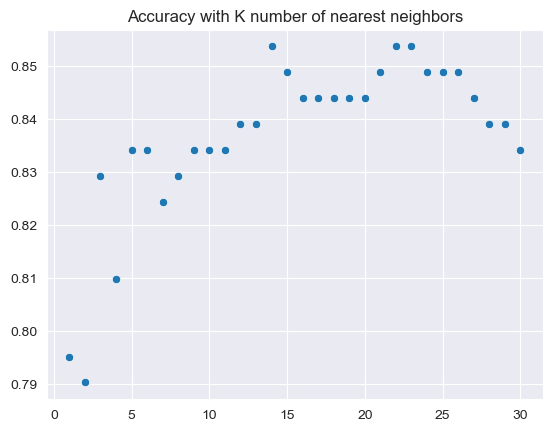

In [72]:
df_KNN = df.copy()

df_KNN['Approved'] = np.where(df_KNN.Approved == '+', 1, 0)

X_KNN = df_KNN.drop(columns=['Approved'])

y_KNN = df_KNN['Approved']

#Create KNN Model to be implemented into pipeline

knn_x_values = []
knn_y_values = []

for i in range(1,31):

    knn = KNeighborsClassifier(n_neighbors=i)

    #create pipeline since some features are categorical
    KNN_transformation = make_column_transformer(
        (OneHotEncoder(), ['Gender','Married', 'Bank_Customer', 'Education_Level', 'Ethnicity', 'Prior_Default','Employed','Citizen']),
        remainder='passthrough')

    pipe = make_pipeline(KNN_transformation, knn)

    X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X_KNN, y_KNN, test_size=0.3, random_state=0)

    pipe.fit(X_train_KNN,y_train_KNN)

    predicted = pipe.predict(X_test_KNN)

    acc = metrics.accuracy_score(y_test_KNN, predicted)
    knn_x_values.append(i)
    knn_y_values.append(acc)

sns.scatterplot(x=knn_x_values, y=knn_y_values).set(title='Accuracy with K number of nearest neighbors')


In [73]:
knn_y_values[13] # k of 14

0.8536585365853658